# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from matplotlib import patches
from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from utils import print_p_val

# ignore pandas copy warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Model prediction on human proteome

In [3]:
pred_human_proteome = pd.read_excel(data_path + "Biomarker_discovery/Probability_scores_human_proteome.xlsx")
pred_human_proteome.columns = ["Uniprot", "Gene Names", "Full", "HC", "CSF_studies", "Brain_detected", 
    "Brain_elevated"]

## Brain datasets (Human Protein Atlas)

In [4]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]

# calculate log2 of brain expression for brain elevated HPA proteome
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])

In [5]:
pred_brain_elevated_exp = pred_human_proteome.merge(brain_exp, on="Uniprot", how="inner")

## Brain protein abundance (PaxDB)

In [6]:
brain_abundance = pd.read_csv(data_path + "PaxDB/Brain_protein_abundance_paxdb.txt", sep="\t", header=10, 
    names=["ID", "Ensembl", "Abundance"])
brain_abundance_uniprot = pd.read_csv(data_path + "PaxDB/Brain_protein_abundance_paxdb_Ensembl_Uniprot.tsv", sep="\t", 
    names=["Ensembl", "Uniprot"])

## Proximity Extension Assay CSF data
Supplementary data from: Del Campo et al. (2022) CSF proteome profiling across the Alzheimer’s disease spectrum reflects the multifactorial nature of the disease and identifies specific biomarker panels. Nature Aging 2, 1040–1053. https://doi.org/10.1038/s43587-022-00300-1

In [7]:
# 642 unique proteins according to publication, PDF content copied into txt file
with open(data_path + "Biomarker_discovery//PEA_proteins_DelCampo2022.txt", "r") as f: 
     lines = f.readlines()

In [8]:
# split into words
word_list = []
for line in lines:
    words = line.split()
    word_list.extend(words)

# split up multiple Uniprot IDs
new_word_list = []
for word in word_list:
    words = word.split(",")
    new_word_list.extend(words)

In [9]:
uniprot_list_pea = []

for x in new_word_list:
    # Uniprot ID is 6 characters long, 8 characters if isoform number is added
    if 6 <= len(x) <= 8:
        if len(x) == 8:
            x = x[:6]
        if (x[0] in ["O", "P", "Q"]) & (x[1].isdigit()):
            uniprot_list_pea.append(x)
    
print("Unique Uniprot IDs of highly confident proteins in PEA CSF dataset:", len(set(uniprot_list_pea))) 
# one unique Uniprot less as one antibody binds Interleukin-12 alpha and beta chain (P29460,P29459) --> ignored, not unique
# other antibody in data set binds only Interleukin-12 beta chain (P29460)

Unique Uniprot IDs of highly confident proteins in PEA CSF dataset: 641


## Uniprot ID mapping

In [10]:
uniprot_mapping = pd.read_csv(data_path + "Uniprot/Human_proteome_Uniprot_Gene_name.tsv", sep="\t", header=0,
    names=["Uniprot", "Gene Symbol"])

# Create protein sets

## Detection method

In [11]:
pea_proteins = set(uniprot_list_pea)
mass_spec_proteins = set(pred_human_proteome[pred_human_proteome["CSF_studies"] > 0]["Uniprot"])
mass_spec_proteins_hc = set(pred_human_proteome[pred_human_proteome["CSF_studies"] > 2]["Uniprot"])

print("PEA-detected CSF proteins (DelCampo2022):", len(pea_proteins), 
    "(%.02f%% of the human proteome)" % (len(pea_proteins)/len(pred_human_proteome)*100))
print("MS-detected CSF proteins:", len(mass_spec_proteins),
    "(%.02f%% of the human proteome)" % (len(mass_spec_proteins)/len(pred_human_proteome)*100))
print("MS-detected high confidence CSF proteins:", len(mass_spec_proteins_hc), 
    "(%.02f%% of the human proteome)" % (len(mass_spec_proteins_hc)/len(pred_human_proteome)*100))

PEA-detected CSF proteins (DelCampo2022): 641 (3.16% of the human proteome)
MS-detected CSF proteins: 5240 (25.81% of the human proteome)
MS-detected high confidence CSF proteins: 2466 (12.15% of the human proteome)


## Brain presence

In [12]:
brain_elevated_proteins = set(brain_elevated["Uniprot"])
brain_detected_proteins = set(brain_detected["Uniprot"])

print("Brain elevated proteins:", len(brain_elevated_proteins), 
    "(%.02f%% of the human proteome)" % (len(brain_elevated_proteins)/len(pred_human_proteome)*100))
print("Brain detected proteins:", len(brain_detected_proteins), 
    "(%.02f%% of the human proteome)" % (len(brain_detected_proteins)/len(pred_human_proteome)*100))

Brain elevated proteins: 2546 (12.54% of the human proteome)
Brain detected proteins: 16021 (78.91% of the human proteome)


## Prediction score

In [13]:
csf_predicted_proteins = set(pred_human_proteome[pred_human_proteome["Full"] > 0.5]["Uniprot"])
non_csf_predicted_proteins = set(pred_human_proteome[pred_human_proteome["Full"] < 0.5]["Uniprot"])

csf_predicted_proteins_hc = set(pred_human_proteome[pred_human_proteome["HC"] > 0.5]["Uniprot"])
non_csf_predicted_proteins_hc = set(pred_human_proteome[pred_human_proteome["HC"] < 0.5]["Uniprot"])

print("Full CSF model predicted proteins:", len(csf_predicted_proteins), 
    "(%.02f%% of the human proteome)" % (len(csf_predicted_proteins)/len(pred_human_proteome)*100))
print("High confidence CSF model predicted proteins:", len(csf_predicted_proteins_hc), 
    "(%.02f%% of the human proteome)" % (len(csf_predicted_proteins_hc)/len(pred_human_proteome)*100))

Full CSF model predicted proteins: 7037 (34.66% of the human proteome)
High confidence CSF model predicted proteins: 5579 (27.48% of the human proteome)


# Model validation on PEA-based CSF proteins

## Overlap of CSF proteome between technologies

## Overlap of CSF and brain proteome 

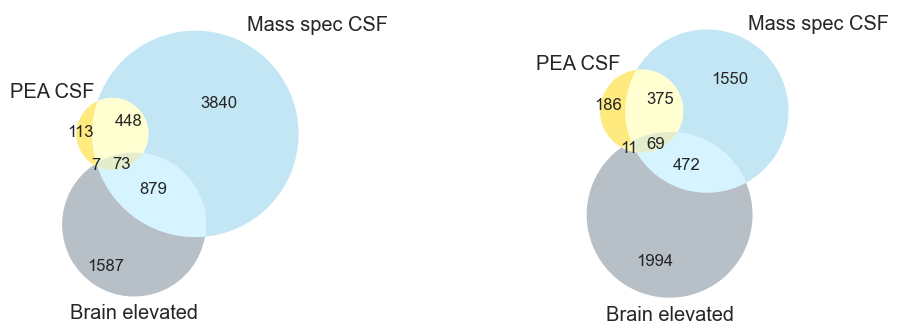

In [14]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))

names = ["PEA CSF", "Mass spec CSF", "Brain elevated"]
colors = ["gold", "skyblue", "slategrey"]

venn3([pea_proteins, mass_spec_proteins, brain_elevated_proteins], names, set_colors=colors, alpha=0.5, ax=ax[0])
venn3([pea_proteins, mass_spec_proteins_hc, brain_elevated_proteins], names, set_colors=colors, alpha=0.5, ax=ax[1])

plt.show()

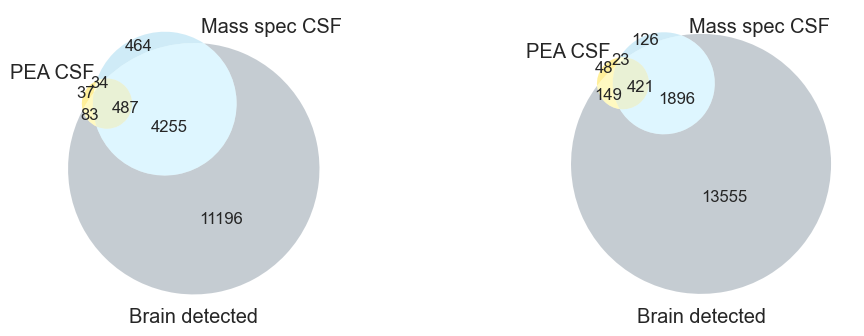

In [15]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))

names = ["PEA CSF", "Mass spec CSF", "Brain detected"]
colors = ["gold", "skyblue", "slategrey"]

venn3([pea_proteins, mass_spec_proteins, brain_detected_proteins], names, set_colors=colors, ax=ax[0])
venn3([pea_proteins, mass_spec_proteins_hc, brain_detected_proteins], names, set_colors=colors, ax=ax[1])

plt.show()

## Overlap of CSF and CSF predicted proteome

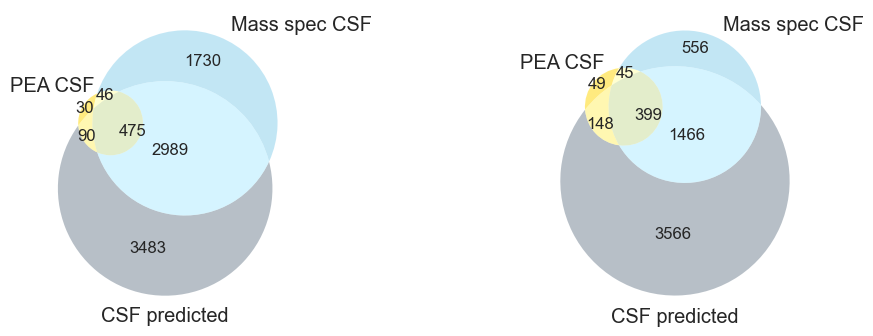

In [16]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))

names = ["PEA CSF", "Mass spec CSF", "CSF predicted"]
colors = ["gold", "skyblue", "slategrey"]

venn3([pea_proteins, mass_spec_proteins, csf_predicted_proteins], names, set_colors=colors, alpha=0.5, ax=ax[0])
venn3([pea_proteins, mass_spec_proteins_hc, csf_predicted_proteins_hc], names, set_colors=colors, alpha=0.5, ax=ax[1])

plt.show()

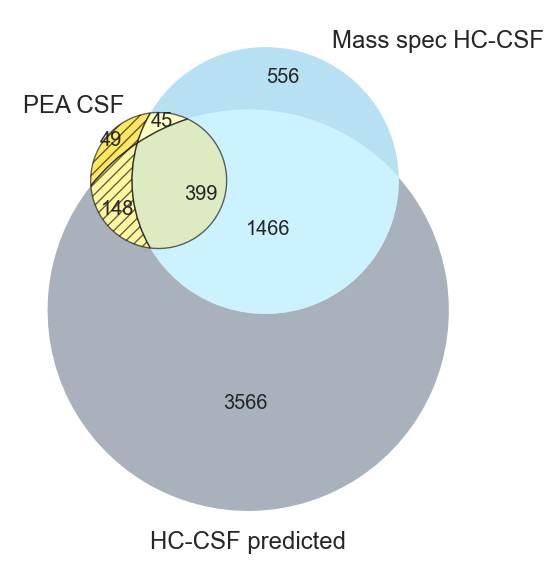

In [17]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,7))

names = ["PEA CSF", "Mass spec HC-CSF", "HC-CSF predicted"]
colors = ["gold", "skyblue", "slategrey"]

v = venn3([pea_proteins, mass_spec_proteins_hc, csf_predicted_proteins_hc], names, set_colors=colors, alpha=0.6)
v.get_patch_by_id("100").set_edgecolor("black")
v.get_patch_by_id("100").set_hatch("///")
v.get_patch_by_id("101").set_edgecolor("black")
v.get_patch_by_id("101").set_hatch("///")
v.get_patch_by_id("111").set_edgecolor("black")
v.get_patch_by_id("110").set_edgecolor("black")

plt.show()
fig.savefig(fig_path + "Venn_CSF3+_PEA_predicted.png", bbox_inches="tight", dpi=300, transparent=True)

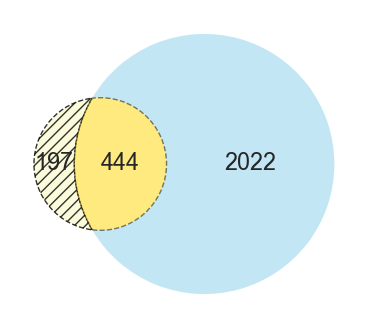

In [18]:
sns.set(style=("ticks"), font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

v = venn2([pea_proteins, mass_spec_proteins_hc], ["", ""], set_colors=("gold", "skyblue"), alpha=0.5)
v.get_patch_by_id("10").set_color("lightgoldenrodyellow")
v.get_patch_by_id("10").set_alpha(0.8)
v.get_patch_by_id("10").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_hatch("///")
v.get_patch_by_id("11").set_color("gold")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("11").set_linestyle("dashed")

plt.show()
fig.savefig(fig_path + "Venn_CSF3+_PEA.png", bbox_inches="tight", dpi=300, transparent=True)

## Brain protein abundance across technologies

In [19]:
brain_abundance["Ensembl"] = brain_abundance["Ensembl"].apply(lambda x: x[5:])
brain_abundance["Abundance"] = np.where(brain_abundance["Abundance"] > 0.0001, np.log2(brain_abundance["Abundance"]), brain_abundance["Abundance"])

brain_abundance = brain_abundance.merge(brain_abundance_uniprot, on="Ensembl", how="inner")
brain_abundance.drop_duplicates(subset=["Uniprot"], inplace=True)

C:\Users\kathi\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
brain_abundance["Technology"] = np.where(brain_abundance["Uniprot"].isin(pea_proteins), "PEA", None)
brain_abundance["Technology"] = np.where(brain_abundance["Uniprot"].isin(mass_spec_proteins_hc), "Mass spectrometry", 
    brain_abundance["Technology"])
brain_abundance["Technology"] = np.where(brain_abundance["Uniprot"].isin(pea_proteins.intersection(mass_spec_proteins_hc)), 
    "Both", brain_abundance["Technology"])

brain_abundance["Prediction"] = np.where(brain_abundance["Uniprot"].isin(csf_predicted_proteins_hc), "CSF", None)
brain_abundance["Prediction"] = np.where(brain_abundance["Uniprot"].isin(non_csf_predicted_proteins_hc), "non-CSF", 
        brain_abundance["Prediction"])

print(brain_abundance["Technology"].value_counts())

Mass spectrometry    1556
Both                  306
PEA                    70
Name: Technology, dtype: int64


In [21]:
# calculate p-values
_, p_MS_PEA = mannwhitneyu(brain_abundance[brain_abundance["Technology"] == "Mass spectrometry"]["Abundance"],
    brain_abundance[brain_abundance["Technology"] == "PEA"]["Abundance"])
_, p_both_PEA = mannwhitneyu(brain_abundance[brain_abundance["Technology"] == "Both"]["Abundance"],
    brain_abundance[brain_abundance["Technology"] == "PEA"]["Abundance"])

# adjust p-values
adjusted_p_expression = multipletests([p_MS_PEA, p_both_PEA], alpha=0.05, method="fdr_bh")[1]
adjusted_p_expression

array([8.71862827e-14, 7.45627594e-06])

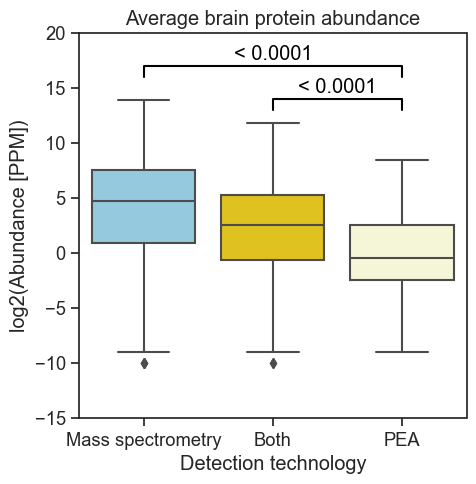

In [22]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.boxplot(data=brain_abundance, x="Technology", y="Abundance", palette=("skyblue", "gold", "lightgoldenrodyellow"))
ax.set(title="Average brain protein abundance", xlabel="Detection technology", ylabel="log2(Abundance [PPM])", ylim=(-15,20))

# add p-value annotations
y, h = 16, 1
ax.plot([0, 0, 2, 2], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(1, y+1.2, print_p_val(adjusted_p_expression[0]), ha="center", va="bottom", color="black")
y, h = 13, 1
ax.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(1.5, y+1.2, print_p_val(adjusted_p_expression[1]), ha="center", va="bottom", color="black")

plt.show()
fig.savefig(fig_path + "Protein_abundance_MS_PEA.png", bbox_inches="tight", dpi=300, transparent=True)

## Fraction of correct predictions

In [23]:
pea_csf_predicted = pea_proteins.intersection(csf_predicted_proteins)
pea_csf_predicted_hc = pea_proteins.intersection(csf_predicted_proteins_hc)

pea_non_ms_proteins = pea_proteins - mass_spec_proteins
pea_non_ms_proteins_hc = pea_proteins - mass_spec_proteins_hc

pea_non_ms_csf_predicted = pea_non_ms_proteins.intersection(csf_predicted_proteins)
pea_non_ms_csf_predicted_hc = pea_non_ms_proteins_hc.intersection(csf_predicted_proteins_hc)

In [24]:
print("All proteins (Number of proteins: %i)" % len(pea_csf_predicted))
print("PEA CSF proteins correctly predicted by full CSF model: %.02f %% (Number of proteins: %i)" 
    % ((len(pea_csf_predicted)/len(pea_proteins)*100), len(pea_csf_predicted)))
print("PEA CSF proteins correctly predicted by high confidence CSF model: %.02f %% (Number of proteins: %i)" 
    % ((len(pea_csf_predicted_hc)/len(pea_proteins)*100), len(pea_csf_predicted_hc)))
print("----------------------")
print("Proteins not detected by mass spectrometry (Number of proteins: %i)" % len(pea_non_ms_proteins))
print("PEA CSF proteins correctly predicted by full CSF model: %.02f %% (Number of proteins: %i)" 
      % ((len(pea_non_ms_csf_predicted)/len(pea_non_ms_proteins)*100), len(pea_non_ms_csf_predicted)))
print("----------------------")
print("Proteins not detected by mass spectrometry with high confidence (Number of proteins: %i)" % len(pea_non_ms_proteins_hc))
print("PEA CSF proteins correctly predicted by high confidence CSF model: %.02f %% (Number of proteins: %i)" 
      % ((len(pea_non_ms_csf_predicted_hc)/len(pea_non_ms_proteins_hc)*100), len(pea_non_ms_csf_predicted_hc)))

All proteins (Number of proteins: 565)
PEA CSF proteins correctly predicted by full CSF model: 88.14 % (Number of proteins: 565)
PEA CSF proteins correctly predicted by high confidence CSF model: 85.34 % (Number of proteins: 547)
----------------------
Proteins not detected by mass spectrometry (Number of proteins: 120)
PEA CSF proteins correctly predicted by full CSF model: 75.00 % (Number of proteins: 90)
----------------------
Proteins not detected by mass spectrometry with high confidence (Number of proteins: 197)
PEA CSF proteins correctly predicted by high confidence CSF model: 75.13 % (Number of proteins: 148)


In [25]:
pea_values = [len(pea_csf_predicted)/len(pea_proteins)*100,
              len(pea_csf_predicted_hc)/len(pea_proteins)*100,
              len(pea_non_ms_csf_predicted)/len(pea_non_ms_proteins)*100,
              len(pea_non_ms_csf_predicted_hc)/len(pea_non_ms_proteins_hc)*100]

pea_df = pd.DataFrame({"Values":pea_values, "Model":["Full CSF", "HC-CSF", "Full CSF", "HC-CSF"], 
    "Proteins":["All", "All", "Only in PEA", "Only in PEA"]})

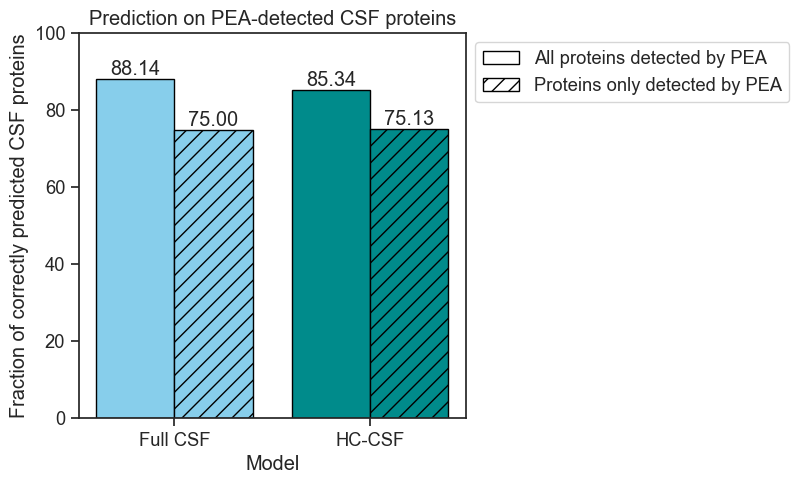

In [26]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)
ax.set_ylim(0,100)

# data for barplot
x = np.arange(2)
y1 = pea_values[:2]
y2 = pea_values[2:]
width = 0.4
  
# grouped bar plot
bar1 = plt.bar(x-0.2, y1, width, color=["skyblue",  "darkcyan"])
bar2 = plt.bar(x+0.2, y2, width, color=["skyblue", "darkcyan"], hatch="//")
ax.bar_label(bar1, fmt="%.2f")
ax.bar_label(bar2, fmt="%.2f")
ax.set(title="Prediction on PEA-detected CSF proteins", xlabel="Model", ylabel="Fraction of correctly predicted CSF proteins")
plt.xticks(ticks=[0, 1], labels=["Full CSF", "HC-CSF"])

# add edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor("black")

# set legend
one = patches.Patch(facecolor="white", edgecolor="black", label="All proteins detected by PEA")
two = patches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Proteins only detected by PEA")
ax.legend(handles=[one, two], bbox_to_anchor=(1, 1))

plt.show()
fig.savefig(fig_path + "Fractions_of_correctly_predicted_PEA_proteins.png", bbox_inches="tight", dpi=300, transparent=True)

## Average predicted probability score

In [27]:
print("All proteins detected in CSF by PEA")
pred_pea = pred_human_proteome[pred_human_proteome["Uniprot"].isin(pea_proteins)]
print(pred_pea[["Full", "HC"]].median())

print("----------------------")
print("All proteins detected in CSF by PEA and not by mass spec")
pred_pea_non_ms = pred_human_proteome[pred_human_proteome["Uniprot"].isin(pea_non_ms_proteins)]
pred_pea_non_ms_hc = pred_human_proteome[pred_human_proteome["Uniprot"].isin(pea_non_ms_proteins_hc)]

pred_pea_non_ms = pd.concat([pred_pea_non_ms, pred_pea_non_ms_hc])
print(pred_pea_non_ms[["Full", "HC"]].median())

All proteins detected in CSF by PEA
Full    0.812586
HC      0.874714
dtype: float64
----------------------
All proteins detected in CSF by PEA and not by mass spec
Full    0.736948
HC      0.790652
dtype: float64


In [28]:
pred_pea_melted = pd.melt(pred_pea, id_vars=["Uniprot"], value_vars=["Full", "HC"], 
    var_name="Model", value_name="Probability")
pred_pea_non_ms_melted = pd.melt(pred_pea_non_ms, id_vars=["Uniprot"], value_vars=["Full", "HC"], 
    var_name="Model", value_name="Probability")

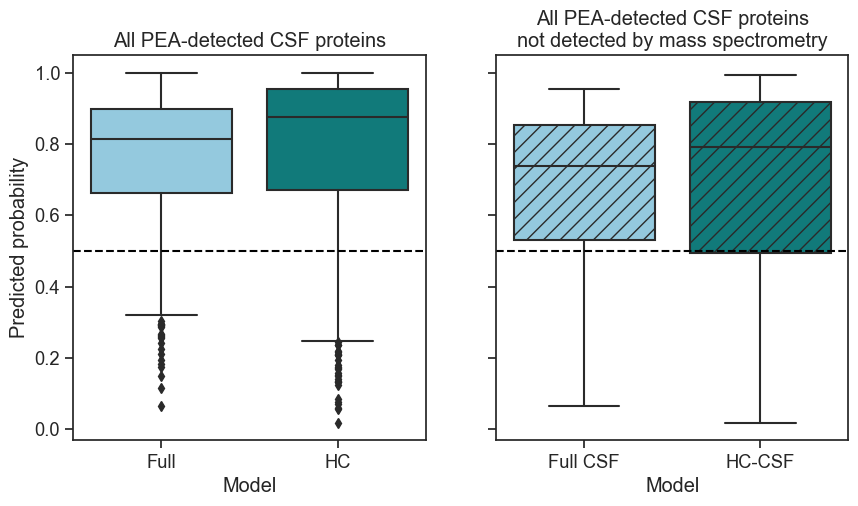

In [29]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.boxplot(data=pred_pea_melted, y="Probability", x="Model", orient="v", palette=["skyblue", "darkcyan"], ax=ax[0])
ax[0].set(xlabel="Model", ylabel="Predicted probability", title="All PEA-detected CSF proteins")
ax[0].axhline(y=0.5, color="black", linestyle="--")
sns.boxplot(data=pred_pea_non_ms_melted, y="Probability", x="Model", orient="v", palette=["skyblue", "darkcyan"], ax=ax[1])
ax[1].set(xlabel="Model", ylabel=None, title="All PEA-detected CSF proteins\nnot detected by mass spectrometry")
ax[1].axhline(y=0.5, color="black", linestyle="--")
plt.xticks(ticks=[0, 1], labels=["Full CSF", "HC-CSF"])


for patch in ax[1].artists:
    patch.set_hatch("//")

plt.show()
fig.savefig(fig_path + "Probability_scores_PEA_validation.png", bbox_inches="tight", dpi=300, transparent=True)